In [ ]:
# BASE
import numpy as np
import pandas as pd
import math
import scipy

# VISUALS
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import panel as pn
pn.extension("tabulator")
import plotly.express as px
import statsmodels.api as sm

# MACHINE LEARNING
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, ARDRegression, SGDRegressor, Ridge, Lasso, ElasticNet, LassoLars
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import LinearSVR, NuSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RepeatedKFold


color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
merged_dataset = pd.read_csv('../data_merge/merged_dataset.csv', encoding='unicode_escape', index_col=0)

merged_dataset.sample(5)

,Quarter,County,SaleCount,Price_median,Immigrants,PrivateHouseholds,PersonsPrivateHouseholds,HouseholdValues,GDPGrowth,GDPGrowthBased,GDPValues,Population,Infliation,InfliationBased,Unemployment
307,2012-Q4,Tipperary,210,93750.0,14780.967164,14648.868655,39455.804025,23.842625,0.000000,3283.566910,11722.812171,1153383,0.388511,4275.576537,3.783321
1420,2023-Q3,Meath,710,320000.0,36307.363396,19059.298295,57191.187500,7.722483,0.363604,7745.503415,34513.620460,1315352,1.160467,5008.993230,1.025857
1152,2021-Q1,Kildare,625,285000.0,19181.858495,20205.242424,60316.000000,8.017969,3.211751,6038.332356,27034.219525,1252066,0.111923,4378.770164,1.618832
89,2010-Q4,Leitrim,44,135541.5,12318.954537,3080.197443,7901.300426,27.372286,0.927569,3221.064407,11087.140140,1143705,-0.168803,4168.501701,3.725426
450,2014-Q2,Kildare,385,200000.0,16342.293297,18026.215862,53919.868750,20.848414,1.295876,3339.521607,12220.758544,1165395,0.079019,4316.932950,3.039215


# Train / Test Split

In [ ]:
train = merged_dataset.loc[merged_dataset['Quarter'] < '2019-Q1']
test = merged_dataset.loc[merged_dataset['Quarter'] >= '2019-Q1']
test.head(5)

,Quarter,County,SaleCount,Price_median,Immigrants,PrivateHouseholds,PersonsPrivateHouseholds,HouseholdValues,GDPGrowth,GDPGrowthBased,GDPValues,Population,Infliation,InfliationBased,Unemployment
936,2019-Q1,Carlow,134,161250.0,23943.486039,5333.927273,14700.150000,9.539023,1.446634,5413.654614,22299.339557,1231784,0.285552,4361.356833,1.277997
937,2019-Q1,Cavan,166,135000.0,23943.486039,6945.881818,19426.795455,9.539023,1.446634,5413.654614,22299.339557,1231784,0.285552,4361.356833,1.277997
938,2019-Q1,Clare,246,162000.0,23943.486039,11181.200000,29939.895455,9.539023,1.446634,5413.654614,22299.339557,1231784,0.285552,4361.356833,1.277997
939,2019-Q1,Cork,1326,230000.0,23943.486039,50693.640909,138363.490909,9.539023,1.446634,5413.654614,22299.339557,1231784,0.285552,4361.356833,1.277997
940,2019-Q1,Donegal,292,115000.0,23943.486039,14946.109091,39899.604545,9.539023,1.446634,5413.654614,22299.339557,1231784,0.285552,4361.356833,1.277997


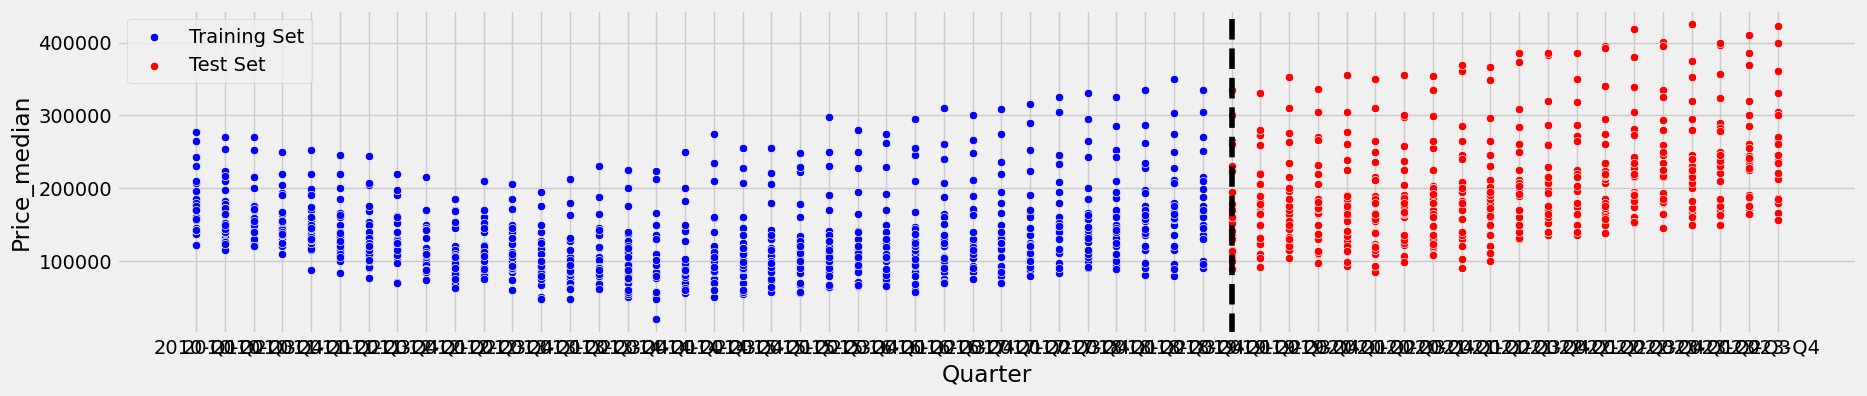

In [ ]:
fig, ax = plt.subplots(figsize=(20, 4))
sns.scatterplot(train, x='Quarter', y='Price_median', label='Training Set', color='blue', ax=ax)
sns.scatterplot(test, x='Quarter', y='Price_median', label='Test Set', color='red', ax=ax)
ax.axvline('2019-Q1', color='black', ls='--')
plt.show()

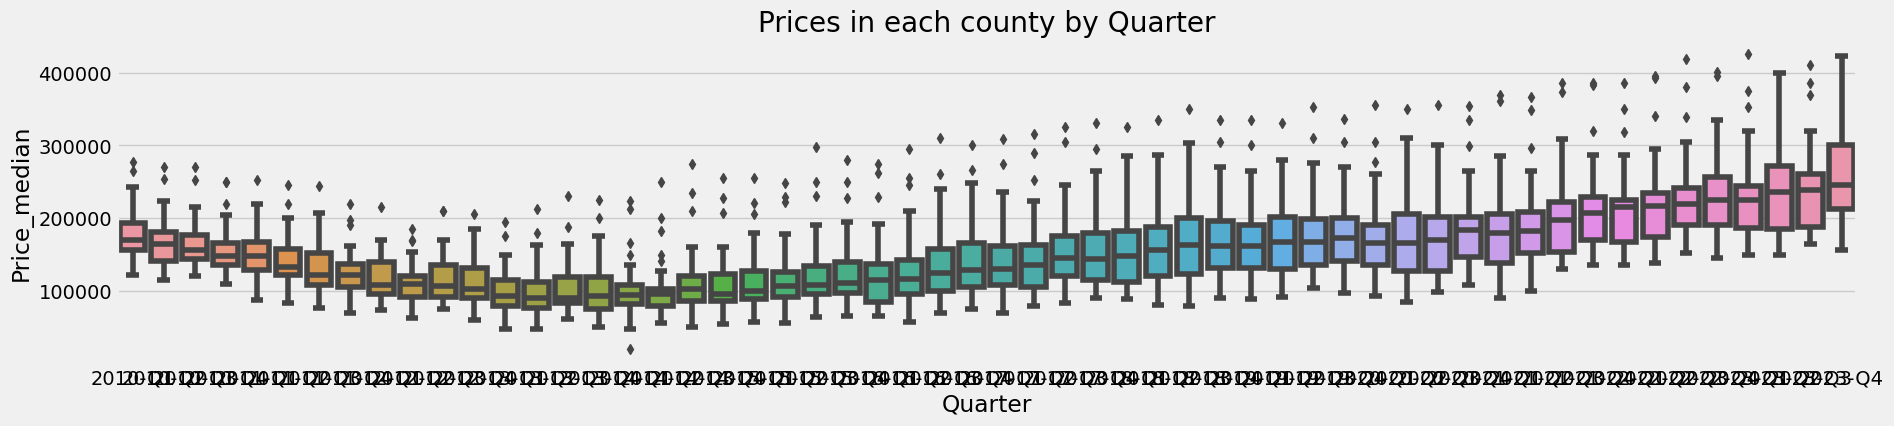

In [ ]:
fig, ax = plt.subplots(figsize=(20, 4))
sns.boxplot(merged_dataset, x='Quarter', y='Price_median')
ax.set_title('Prices in each county by Quarter')
plt.show()

# Feature Creation

In [ ]:
COUNTIES = ['Carlow', 'Cavan', 'Clare', 'Cork', 'Donegal', 'Dublin', 'Galway',
            'Kerry', 'Kildare', 'Kilkenny', 'Laois', 'Leitrim', 'Limerick',
            'Longford', 'Louth', 'Mayo', 'Meath', 'Monaghan', 'Offaly',
            'Roscommon', 'Sligo', 'Tipperary', 'Waterford', 'Westmeath',
            'Wexford', 'Wicklow']

def add_county_columns(data):
  county_columns = {}
  for county in COUNTIES:
    county_columns[county] = data['County'] == county
  data = data.assign(**county_columns)
  data = data.drop(['County'], axis=1)
  return data

train = add_county_columns(train)
test = add_county_columns(test)

train.sample(5)

,Quarter,SaleCount,Price_median,Immigrants,PrivateHouseholds,PersonsPrivateHouseholds,HouseholdValues,GDPGrowth,GDPGrowthBased,GDPValues,...,Meath,Monaghan,Offaly,Roscommon,Sligo,Tipperary,Waterford,Westmeath,Wexford,Wicklow
891,2018-Q3,388,157000.0,23924.666187,13942.051136,36031.156250,10.115756,1.841536,5231.490035,21669.049186,...,False,False,False,False,False,False,False,False,False,False
297,2012-Q4,74,60000.0,14780.967164,3067.944413,7841.198153,23.842625,0.000000,3283.566910,11722.812171,...,False,False,False,False,False,False,False,False,False,False
455,2014-Q2,73,60000.0,16342.293297,3715.408949,10015.707718,20.848414,1.295876,3339.521607,12220.758544,...,False,False,False,False,False,False,False,False,False,False
376,2013-Q3,255,118943.0,15846.233504,17529.626894,47267.734848,22.839242,0.279300,3293.658207,11960.862935,...,False,False,False,False,False,False,False,False,False,False
628,2016-Q1,318,85000.0,19744.558752,14595.346801,39278.941304,13.054505,0.673513,4530.704749,17706.342014,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
def add_date_columns(data):
  year = data['Quarter'].apply(lambda x: x.split('-')[0]).astype(int)
  quarter_number = data['Quarter'].apply(lambda x: x.split('-')[1][-1]).astype(int)
  data = data.assign(year=year, quarternum=quarter_number)
  return data

train = add_date_columns(train)
test = add_date_columns(test)

test.sample(5)

,Quarter,SaleCount,Price_median,Immigrants,PrivateHouseholds,PersonsPrivateHouseholds,HouseholdValues,GDPGrowth,GDPGrowthBased,GDPValues,...,Offaly,Roscommon,Sligo,Tipperary,Waterford,Westmeath,Wexford,Wicklow,year,quarternum
1026,2019-Q4,649,170000.0,24687.466684,18518.677557,49964.392045,9.017602,1.075010,5628.921977,23074.366213,...,False,False,False,False,False,False,False,False,2019,4
1172,2021-Q2,303,185000.0,18009.321246,11510.571875,30723.305824,7.669805,3.803142,6232.268572,28338.573278,...,False,False,False,False,False,False,False,False,2021,2
1280,2022-Q2,675,260100.0,25348.155803,7712.336068,20187.473373,6.486447,2.542768,7212.132678,32863.957594,...,False,False,False,False,False,False,False,False,2022,2
1360,2023-Q1,801,352422.0,34362.298972,21235.177273,62905.900000,6.729856,0.779871,7646.832313,34037.560368,...,False,False,False,False,False,False,False,False,2023,1
938,2019-Q1,246,162000.0,23943.486039,11181.200000,29939.895455,9.539023,1.446634,5413.654614,22299.339557,...,False,False,False,False,False,False,False,False,2019,1


# Create models

In [ ]:
FEATURES = [col for col in train.columns if col not in ['Quarter', 'Price_median']]
TARGET = 'Price_median'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
tested_models = [
    LinearRegression(),
    ARDRegression(),
    SGDRegressor(random_state=7),
    Ridge(random_state=7),
    Lasso(random_state=7),
    ElasticNet(random_state=7),
    LassoLars(random_state=7),
    AdaBoostRegressor(random_state=7),
    BaggingRegressor(random_state=7),
    ExtraTreesRegressor(random_state=7),
    GradientBoostingRegressor(random_state=7),
    RandomForestRegressor(random_state=7),
    LinearSVR(random_state=7),
    NuSVR(),
    SVR(),
    KNeighborsRegressor(),
    GaussianProcessRegressor(random_state=7),
    PLSRegression(),
    DecisionTreeRegressor(random_state=7),
    ExtraTreeRegressor(random_state=7),
    MLPRegressor(random_state=7),
    xgb.XGBRegressor(random_state=7),
]

model_rmse = []
for model in tested_models:
  print('Testing', model.__class__.__name__)
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  rmse = math.sqrt(mean_squared_error(y_test, pred))
  model_rmse.append((rmse, model.__class__.__name__))

model_rmse.sort()
print('RMSE of tested models with default settings:')
for score, model_name in model_rmse:
  print('\tModel type %s had %.2f RMSE' % (model_name, score))

Testing LinearRegression
Testing ARDRegression
Testing SGDRegressor
Testing Ridge
Testing Lasso


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.926e+10, tolerance: 2.734e+08
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.274e+11, tolerance: 2.734e+08
  model = cd_fast.enet_coordinate_descent(


Testing ElasticNet
Testing LassoLars
Testing AdaBoostRegressor
Testing BaggingRegressor
Testing ExtraTreesRegressor
Testing GradientBoostingRegressor
Testing RandomForestRegressor
Testing LinearSVR
Testing NuSVR


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Testing SVR
Testing KNeighborsRegressor
Testing GaussianProcessRegressor
Testing PLSRegression
Testing DecisionTreeRegressor
Testing ExtraTreeRegressor
Testing MLPRegressor


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Testing XGBRegressor
RMSE of tested models with default settings:
	Model type Ridge had 22680.58 RMSE
	Model type Lasso had 25005.98 RMSE
	Model type ARDRegression had 30557.24 RMSE
	Model type LassoLars had 38653.42 RMSE
	Model type LinearRegression had 40460.09 RMSE
	Model type ExtraTreesRegressor had 48288.12 RMSE
	Model type ExtraTreeRegressor had 49223.79 RMSE
	Model type GradientBoostingRegressor had 49720.34 RMSE
	Model type RandomForestRegressor had 51228.23 RMSE
	Model type DecisionTreeRegressor had 51914.20 RMSE
	Model type BaggingRegressor had 52675.23 RMSE
	Model type XGBRegressor had 57866.40 RMSE
	Model type AdaBoostRegressor had 57875.66 RMSE
	Model type LinearSVR had 59570.57 RMSE
	Model type KNeighborsRegressor had 62415.68 RMSE
	Model type MLPRegressor had 65825.20 RMSE
	Model type ElasticNet had 103295.29 RMSE
	Model type NuSVR had 105623.52 RMSE
	Model type SVR had 108596.18 RMSE
	Model type PLSRegression had 119792.11 RMSE
	Model type GaussianProcessRegressor had 2

In [ ]:
tested_models = [
    ('Ridge#1', Ridge(alpha=0, random_state=7)),
    ('Ridge#2', Ridge(alpha=0.1, random_state=7)),
    ('Ridge#3', Ridge(alpha=0.5, random_state=7)),
    ('Ridge#4', Ridge(alpha=0.9, random_state=7)),
    ('Ridge#5', Ridge(solver='svd', random_state=7)),
    ('Ridge#6', Ridge(solver='cholesky', random_state=7)),
    ('Ridge#7', Ridge(solver='lsqr', random_state=7)),
    ('Ridge#8', Ridge(solver='sparse_cg', random_state=7)),
    ('Ridge#9', Ridge(solver='sag', random_state=7)),
    ('Ridge#10', Ridge(solver='saga', random_state=7)),

    ('Lasso#1', Lasso(alpha=0, random_state=7)),
    ('Lasso#2', Lasso(alpha=0.1, random_state=7)),
    ('Lasso#3', Lasso(alpha=0.5, random_state=7)),
    ('Lasso#4', Lasso(alpha=0.9, random_state=7)),

    ('ARDRegression#1', ARDRegression(n_iter=1000)),

    ('LassoLars#1', LassoLars(alpha=0, random_state=7)),
    ('LassoLars#2', LassoLars(alpha=0.1, random_state=7)),
    ('LassoLars#3', LassoLars(alpha=0.5, random_state=7)),
    ('LassoLars#4', LassoLars(alpha=0.9, random_state=7)),
    ('LassoLars#5', LassoLars(max_iter=1000, random_state=7)),

    ('ExtraTreesRegressor#1', ExtraTreesRegressor(n_estimators=200, random_state=7)),
    ('ExtraTreesRegressor#2', ExtraTreesRegressor(min_samples_leaf=2, random_state=7)),

    ('GradientBoostingRegressor#1', GradientBoostingRegressor(learning_rate=0.01, random_state=7)),
    ('GradientBoostingRegressor#2', GradientBoostingRegressor(learning_rate=0.05, random_state=7)),
    ('GradientBoostingRegressor#3', GradientBoostingRegressor(learning_rate=0.2, random_state=7)),
    ('GradientBoostingRegressor#4', GradientBoostingRegressor(n_estimators=500, random_state=7)),

    ('BaggingRegressor#1', BaggingRegressor(estimator=Ridge(random_state=7), random_state=7)),
    ('BaggingRegressor#2', BaggingRegressor(n_estimators=100, random_state=7)),

    ('XGBRegressor#1', xgb.XGBRegressor(booster='gbtree', random_state=7)),
    ('XGBRegressor#1', xgb.XGBRegressor(n_estimators=1000, random_state=7)),
    ('XGBRegressor#1', xgb.XGBRegressor(learning_rate=0.01, random_state=7)),
]

model_rmse = []
for model_name, model in tested_models:
  print('Testing', model_name)
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  rmse = math.sqrt(mean_squared_error(y_test, pred))
  model_rmse.append((rmse, model_name))

model_rmse.sort()
print('RMSE of tested models with default settings:')
for score, model_name in model_rmse:
  print('\tModel type %s had %.2f RMSE' % (model_name, score))

Testing Ridge#1
Testing Ridge#2
Testing Ridge#3
Testing Ridge#4
Testing Ridge#5
Testing Ridge#6


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.80851e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Testing Ridge#7
Testing Ridge#8
Testing Ridge#9


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Testing Ridge#10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
<ipython-input-95-073dfad7ca78>:45: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(X_train, y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.811e+10, tolerance: 2.734e+08 Linear regression models with null weight for the l1 regularization term are more efficiently f

Testing Lasso#1
Testing Lasso#2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.823e+10, tolerance: 2.734e+08
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.869e+10, tolerance: 2.734e+08
  model = cd_fast.enet_coordinate_descent(


Testing Lasso#3
Testing Lasso#4


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.915e+10, tolerance: 2.734e+08
  model = cd_fast.enet_coordinate_descent(


Testing ARDRegression#1
Testing LassoLars#1
Testing LassoLars#2
Testing LassoLars#3
Testing LassoLars#4
Testing LassoLars#5
Testing ExtraTreesRegressor#1
Testing ExtraTreesRegressor#2
Testing GradientBoostingRegressor#1
Testing GradientBoostingRegressor#2
Testing GradientBoostingRegressor#3
Testing GradientBoostingRegressor#4
Testing BaggingRegressor#1
Testing BaggingRegressor#2
Testing XGBRegressor#1
Testing XGBRegressor#1
Testing XGBRegressor#1
RMSE of tested models with default settings:
	Model type Ridge#5 had 22680.58 RMSE
	Model type Ridge#6 had 22680.58 RMSE
	Model type Ridge#4 had 22779.71 RMSE
	Model type BaggingRegressor#1 had 23163.61 RMSE
	Model type Lasso#1 had 24878.87 RMSE
	Model type Lasso#2 had 24889.76 RMSE
	Model type Lasso#3 had 24939.81 RMSE
	Model type Lasso#4 had 24992.65 RMSE
	Model type Ridge#3 had 26039.24 RMSE
	Model type ARDRegression#1 had 30557.24 RMSE
	Model type Ridge#2 had 36552.50 RMSE
	Model type LassoLars#5 had 38653.42 RMSE
	Model type LassoLars#4 h

In [ ]:
ridge_model = Ridge(random_state=7)
cv5 = RepeatedKFold(n_splits=5, n_repeats=3, random_state=7)
grid = dict()
grid['alpha'] = [a/100 for a in range(0, 100, 5)]
grid['max_iter'] = [None, 5000, 10000, 25000]
grid['solver'] = ['auto', 'svd', 'cholesky', 'lsqr']
search = GridSearchCV(ridge_model, grid, scoring='neg_mean_squared_error', cv=cv5, n_jobs=-1)
results = search.fit(X_train, y_train)

print('RMSE: %.3f' % math.sqrt(-results.best_score_))
print('Parameters: %s' % results.best_params_)

RMSE: 13528.638
Parameters: {'alpha': 0.05, 'max_iter': None, 'solver': 'svd'}


In [ ]:
model = Ridge(alpha=0.05, solver='svd', random_state=7)
model.fit(X_train, y_train)
test['prediction'] = model.predict(X_test)

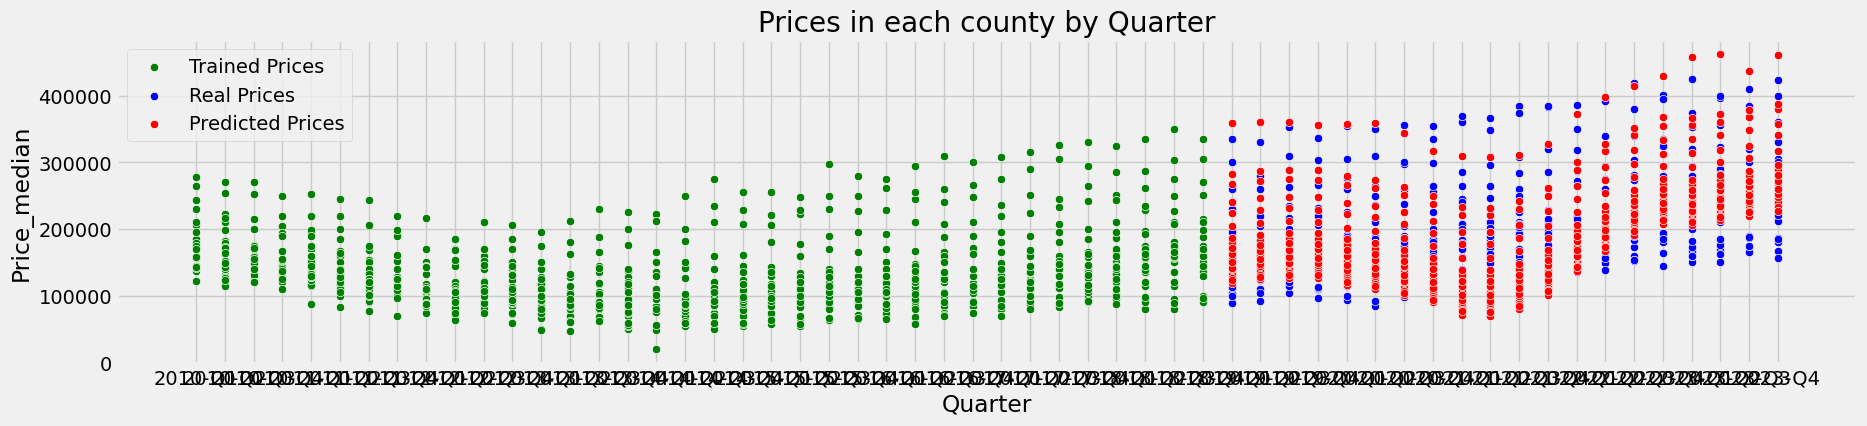

In [ ]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.set_title('Prices in each county by Quarter')
sns.scatterplot(train, x='Quarter', y='Price_median', label='Trained Prices', color='green', ax=ax)
sns.scatterplot(test, x='Quarter', y='Price_median', label='Real Prices', color='blue', ax=ax)
sns.scatterplot(test, x='Quarter', y='prediction', label='Predicted Prices', color='red', ax=ax)
plt.show()

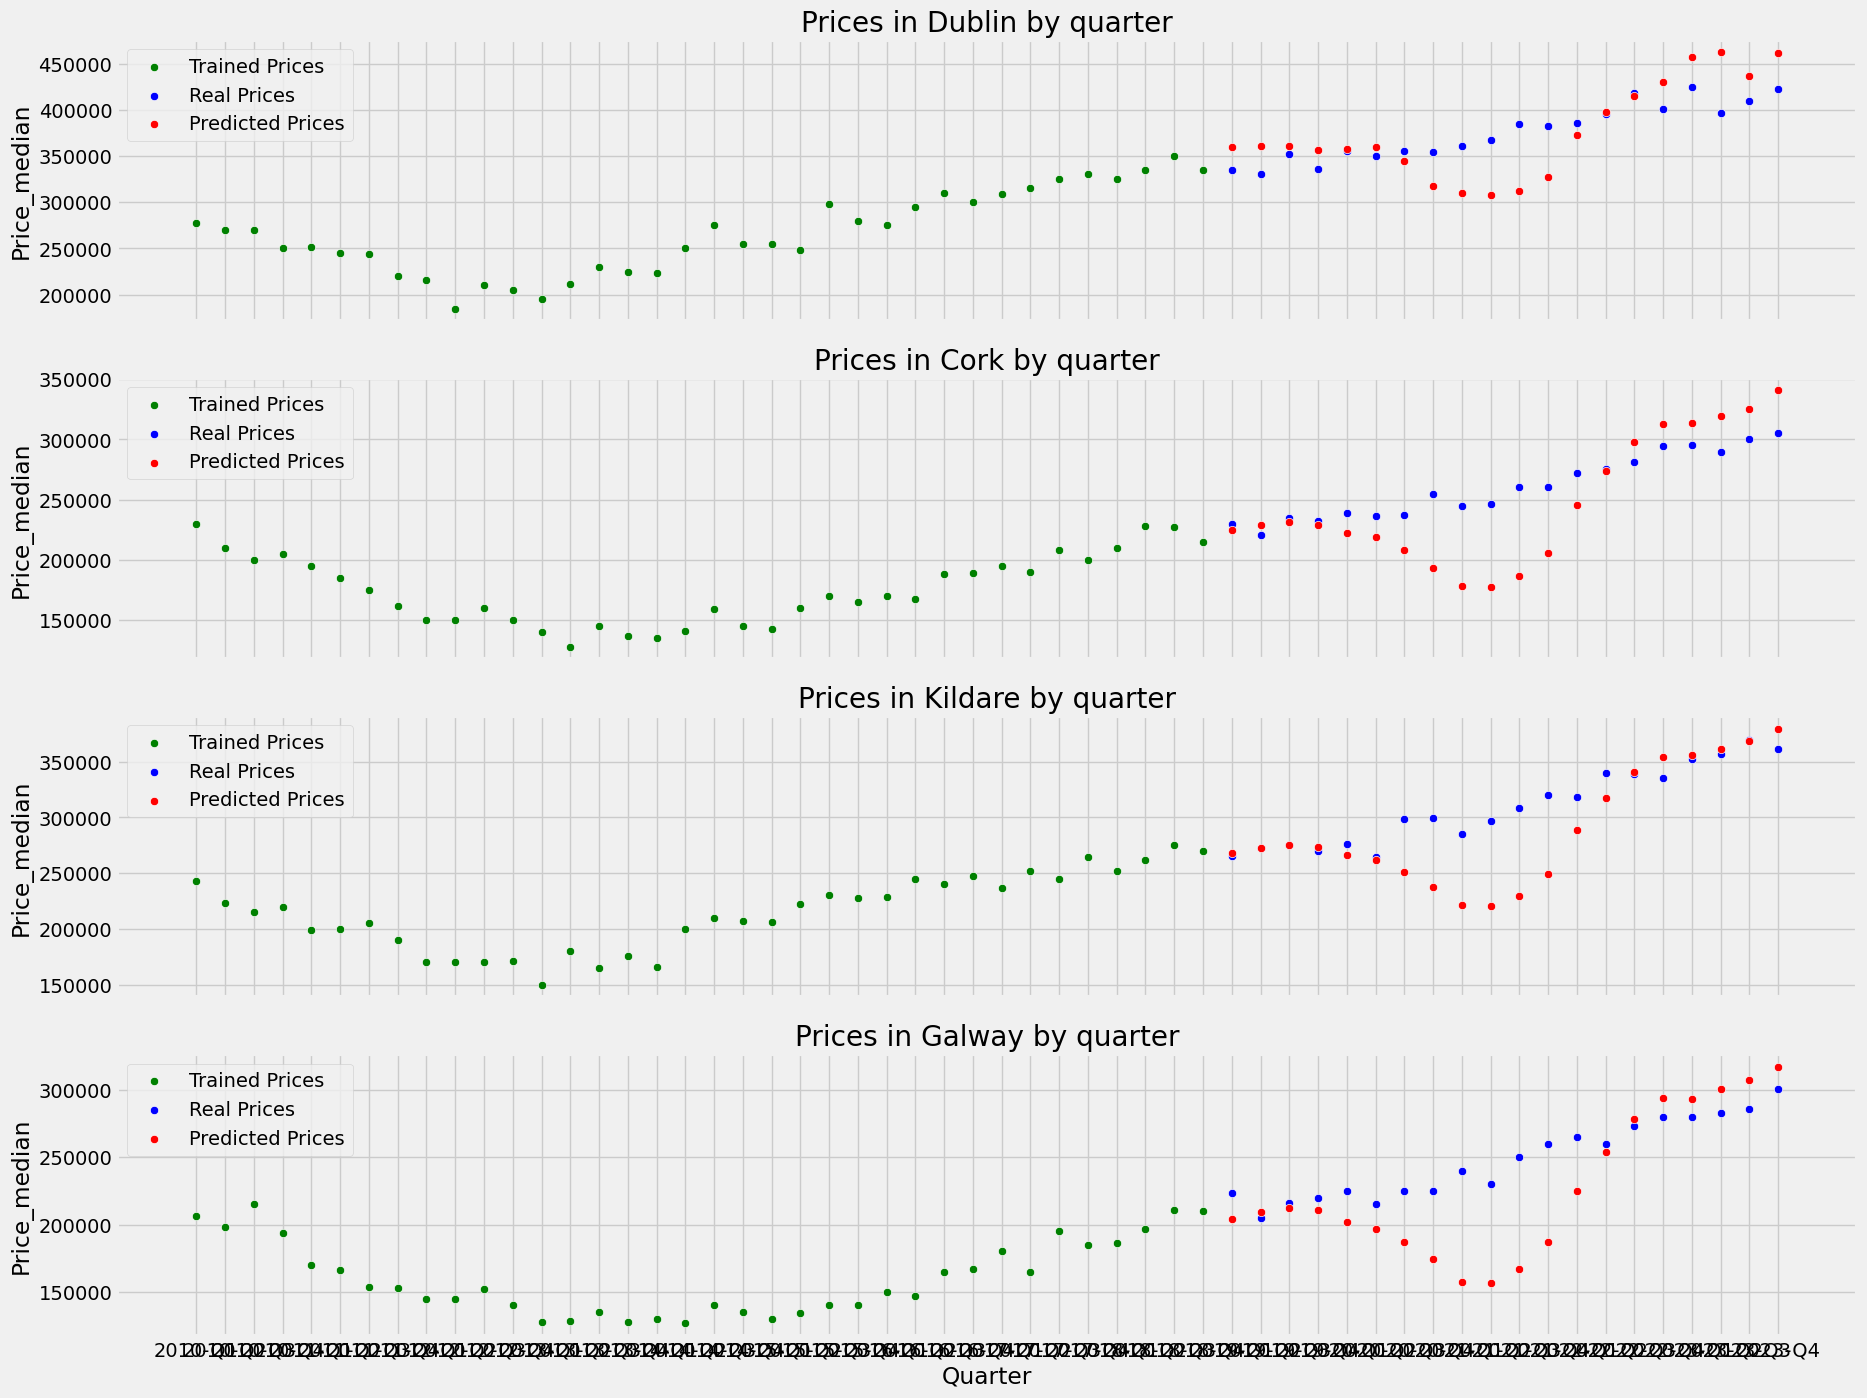

In [ ]:
fig, axes = plt.subplots(4, figsize=(20, 16), sharex=True)
for c, ax in zip(['Dublin', 'Cork', 'Kildare', 'Galway'], axes):
  ax.set_title('Prices in %s by quarter' % c)
  county_train, county_test = train[train[c]], test[test[c]]
  sns.scatterplot(county_train, x='Quarter', y='Price_median', label='Trained Prices', color='green', ax=ax)
  sns.scatterplot(county_test, x='Quarter', y='Price_median', label='Real Prices', color='blue', ax=ax)
  sns.scatterplot(county_test, x='Quarter', y='prediction', label='Predicted Prices', color='red', ax=ax)

plt.show()

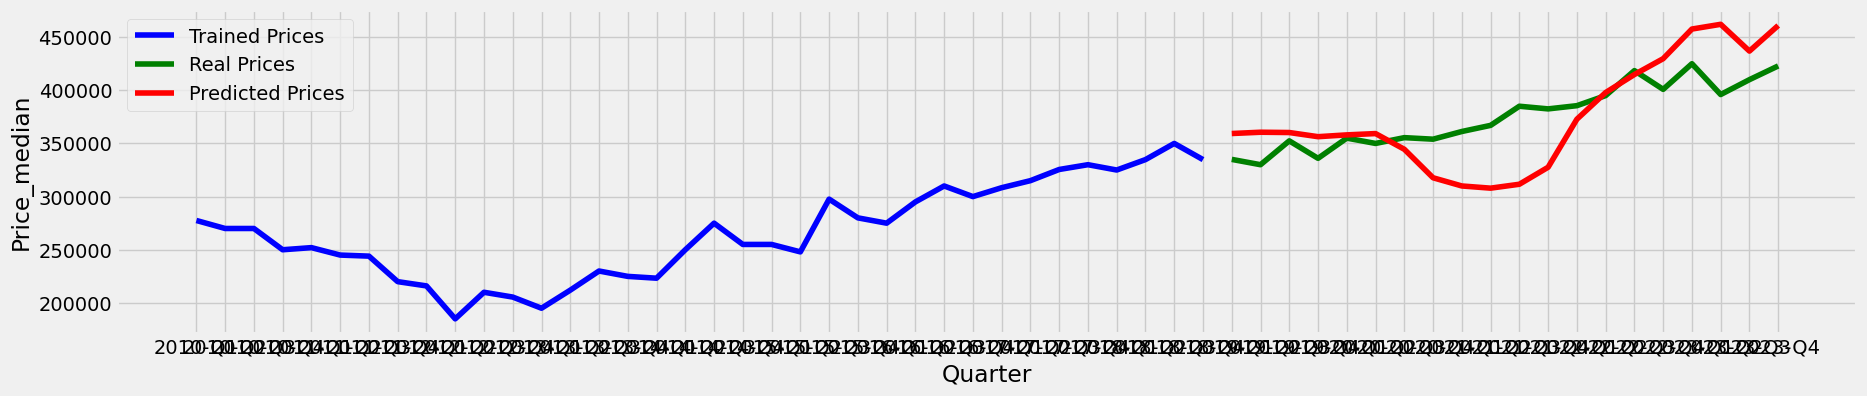

In [ ]:
fig, ax = plt.subplots(figsize=(20, 4))
dublin_train, dublin_test = train[train['Dublin']], test[test['Dublin']]
sns.lineplot(dublin_train, x='Quarter', y='Price_median', label='Trained Prices', color='blue', ax=ax)
sns.lineplot(dublin_test, x='Quarter', y='Price_median', label='Real Prices', color='green', ax=ax)
sns.lineplot(dublin_test, x='Quarter', y='prediction', label='Predicted Prices', color='red', ax=ax)
plt.show()

# Future prediction

In [ ]:
df = merged_dataset.copy()
df = add_county_columns(df)
df = add_date_columns(df)

X = df[FEATURES]
y = df[TARGET]

df.sample(5)

,Quarter,SaleCount,Price_median,Immigrants,PrivateHouseholds,PersonsPrivateHouseholds,HouseholdValues,GDPGrowth,GDPGrowthBased,GDPValues,...,Offaly,Roscommon,Sligo,Tipperary,Waterford,Westmeath,Wexford,Wicklow,year,quarternum
669,2016-Q2,145,80000.0,20156.255039,5996.409187,15904.077147,13.105294,0.254906,4561.219643,17664.900064,...,False,True,False,False,False,False,False,False,2016,2
756,2017-Q2,282,135000.0,23690.419229,10980.671875,29479.310369,11.689157,2.065119,4623.069679,19275.327500,...,False,False,False,False,False,False,False,False,2017,2
200,2011-Q4,65,96916.0,13849.332633,6693.576713,19081.123871,25.833585,0.113637,3279.839784,11363.483593,...,True,False,False,False,False,False,False,False,2011,4
701,2016-Q3,377,260000.0,20778.408714,12319.722608,35294.821672,13.053779,0.026707,4572.846452,17746.283608,...,False,False,False,False,False,False,False,True,2016,3
302,2012-Q4,297,145000.0,14780.967164,15592.339820,46672.357292,23.842625,0.000000,3283.566910,11722.812171,...,False,False,False,False,False,False,False,False,2012,4


In [ ]:
model = Ridge(alpha=0.05, solver='svd', random_state=7)
model.fit(X, y)
pred = model.predict(X)
rmse = math.sqrt(mean_squared_error(y, pred))
print('RMSE on training set: %.3f' % rmse)

RMSE on training set: 14070.372


In [ ]:
future_data = {col: [] for col in merged_dataset.columns if col != 'Price_median'}

future_years = [2024, 2024, 2024, 2024, 2025, 2025, 2025, 2025, 2026, 2026, 2026, 2026]
future_quarternums = [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4]
future_quarters = ['%d-Q%d' % (y, q) for y, q in zip(future_years, future_quarternums)]

def predicted_interpolation(data, county, feature):
  county_data = data[data['County'] == county]
  X = county_data[['Quarter']]
  X = add_date_columns(X[['Quarter']]).drop('Quarter', axis=1)
  y = county_data[[feature]]

  model = Ridge(alpha=0.05, solver='svd', random_state=7)
  model.fit(X, y)

  future_X = pd.DataFrame({'year': future_years, 'quarternum': future_quarternums})
  return model.predict(future_X)

for county in COUNTIES:
  future_data['Quarter'].extend(future_quarters)
  future_data['County'].extend([county] * 12)
  for feature in merged_dataset.columns:
    if feature in ['Quarter', 'County', 'Price_median']:
      continue
    pred = predicted_interpolation(merged_dataset, county, feature)
    future_data[feature].extend(pred.flatten())

future_df = pd.DataFrame(future_data)

future_df.sample(5)

,Quarter,County,SaleCount,Immigrants,PrivateHouseholds,PersonsPrivateHouseholds,HouseholdValues,GDPGrowth,GDPGrowthBased,GDPValues,Population,Infliation,InfliationBased,Unemployment
265,2024-Q2,Waterford,473.753991,30570.339726,12111.061917,31675.993355,1.918415,2.451044,7460.777300,33688.534221,1.303867e+06,1.015771,4656.086124,0.476258
159,2024-Q4,Longford,144.470229,31522.976206,4154.390530,11244.422019,1.210494,2.635683,7621.172046,34558.364598,1.310419e+06,1.083305,4686.204324,0.388111
252,2024-Q1,Tipperary,429.952390,30094.021486,15645.263752,41735.246667,2.272376,2.358725,7380.579928,33253.619032,1.300591e+06,0.982004,4641.027024,0.520332
63,2024-Q4,Dublin,5224.168351,31522.976206,104441.745672,279366.718083,1.210494,2.635683,7621.172046,34558.364598,1.310419e+06,1.083305,4686.204324,0.388111
53,2025-Q2,Donegal,445.251363,31946.472906,15628.790326,41182.000130,0.150275,2.569719,7818.269933,35561.696144,1.316870e+06,1.107744,4694.095751,0.232535


In [ ]:
future_df = add_county_columns(future_df)
future_df = add_date_columns(future_df)

future_df['prediction'] = model.predict(future_df[FEATURES])

future_df.sample(5)

,Quarter,SaleCount,Immigrants,PrivateHouseholds,PersonsPrivateHouseholds,HouseholdValues,GDPGrowth,GDPGrowthBased,GDPValues,Population,...,Roscommon,Sligo,Tipperary,Waterford,Westmeath,Wexford,Wicklow,year,quarternum,prediction
304,2025-Q1,524.309700,31470.154666,13861.628502,39469.344052,0.504236,2.477399,7738.072560,35126.780955,1.313594e+06,...,False,False,False,False,False,False,True,2025,1,344372.286181
124,2025-Q1,170.414497,31470.154666,7992.418870,23253.282021,0.504236,2.477399,7738.072560,35126.780955,1.313594e+06,...,False,False,False,False,False,False,False,2025,1,211447.250956
185,2025-Q2,426.169630,31946.472906,13242.913078,33973.942227,0.150275,2.569719,7818.269933,35561.696144,1.316870e+06,...,False,False,False,False,False,False,False,2025,2,176392.700415
18,2025-Q3,213.268508,31948.455087,7416.398707,20713.274765,-0.755905,2.876138,7848.080958,35785.762993,1.317845e+06,...,False,False,False,False,False,False,False,2025,3,181854.791412
40,2025-Q1,1712.400912,31470.154666,54175.617123,147593.230461,0.504236,2.477399,7738.072560,35126.780955,1.313594e+06,...,False,False,False,False,False,False,False,2025,1,283147.421604


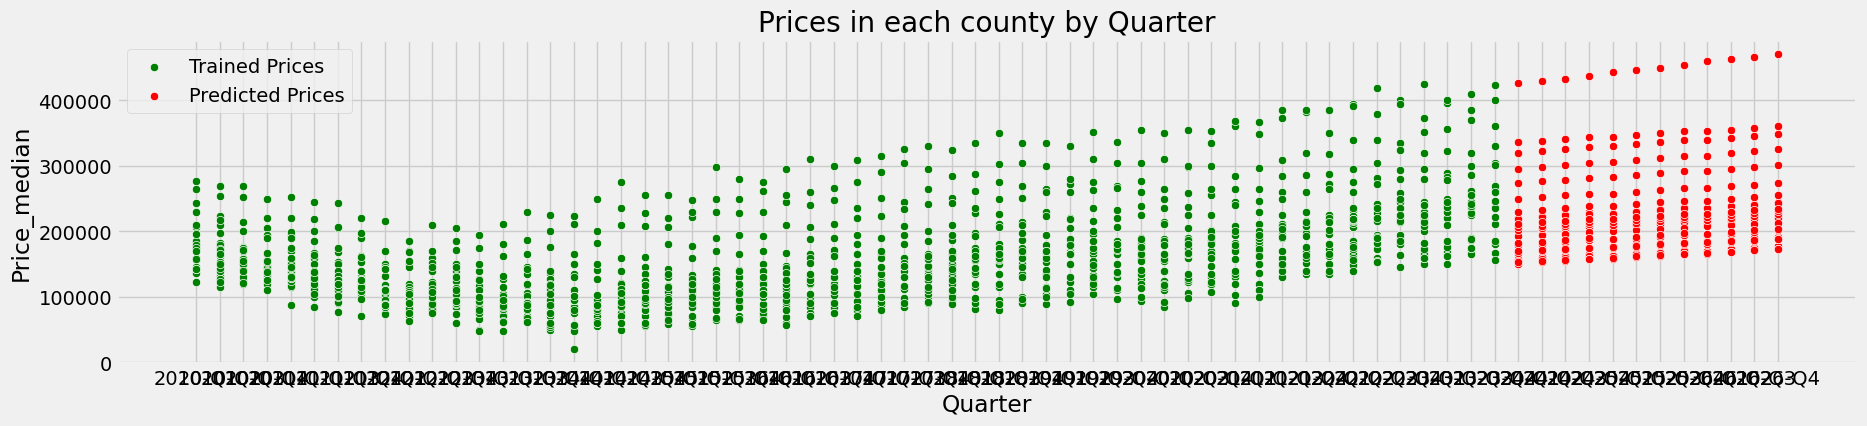

In [ ]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.set_title('Prices in each county by Quarter')
sns.scatterplot(df, x='Quarter', y='Price_median', label='Trained Prices', color='green', ax=ax)
sns.scatterplot(future_df, x='Quarter', y='prediction', label='Predicted Prices', color='blue', ax=ax)
plt.show()

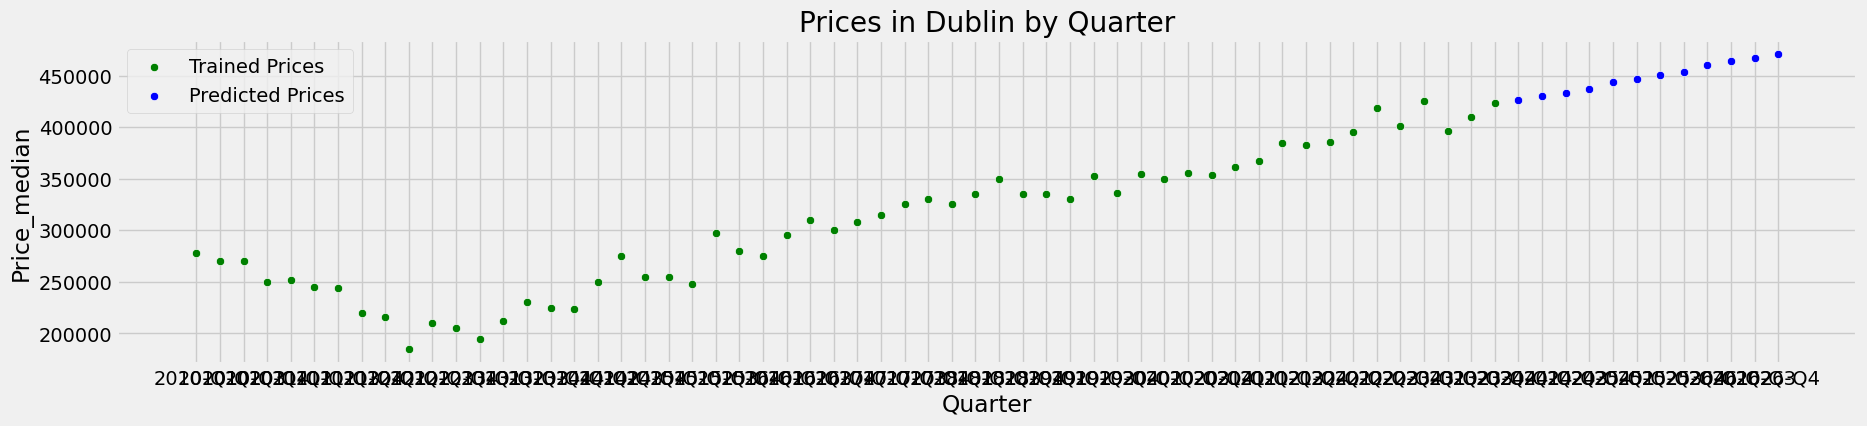

In [ ]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.set_title('Prices in Dublin by Quarter')
dublin_train, dublin_test = df[df['Dublin']], future_df[future_df['Dublin']]
sns.scatterplot(dublin_train, x='Quarter', y='Price_median', label='Trained Prices', color='green', ax=ax)
sns.scatterplot(dublin_test, x='Quarter', y='prediction', label='Predicted Prices', color='blue', ax=ax)
plt.show()